In [1]:
from cil.framework import ImageGeometry
from cil.utilities.jupyter import islicer
from cil.utilities.display import show2D, show1D, show_geometry
from cil.processors import CentreOfRotationCorrector, TransmissionAbsorptionConverter, RingRemover, Padder, Slicer
from cil.recon import FBP
from cil.io import NEXUSDataWriter
from cil.io.utilities import HDF5_utilities
import numpy as np
import os
import hdf5plugin
from cil.framework import AcquisitionGeometry, AcquisitionData
import matplotlib.pyplot as plt
from tomopy.prep.phase import retrieve_phase

/home/bgb37495/miniconda3/envs/cil_esrf/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
filename = '/data/ESRF/Wedgescan_Iterative_ASSB/InSitu-LPSCL-20Ton-30Min_0001.h5'#
angles = HDF5_utilities.read(filename, '/4.1/measurement/hrsrot')
ds_metadata = HDF5_utilities.get_dataset_metadata(filename, '4.1/instrument/pco2linux/data')

In [42]:
angles[0]

0.0284375

In [3]:
roi = [slice(None), slice(450, 950), slice(None)]
source_sel=tuple(roi)

In [4]:
filename = '/data/ESRF/Wedgescan_Iterative_ASSB/flats.h5'#
HDF5_utilities.print_metadata(filename, '/entry_0000/measurement', 2)
HDF5_utilities.get_dataset_metadata(filename, 'entry_0000/measurement/data')
flats = HDF5_utilities.read(filename, 'entry_0000/measurement/data', tuple(source_sel))
flat = np.mean(flats, axis = 0) #median?


filename = '/data/ESRF/Wedgescan_Iterative_ASSB/darks.h5'#
HDF5_utilities.print_metadata(filename, 'entry_0000/measurement', 2)
HDF5_utilities.get_dataset_metadata(filename, 'entry_0000/measurement/data')
darks = HDF5_utilities.read(filename, 'entry_0000/measurement/data', tuple(source_sel))
dark = np.mean(darks, axis = 0) 

	 - data : <HDF5 dataset "data": shape (60, 2160, 2560), type "<i4">
			 - interpretation : image
	 - data : <HDF5 dataset "data": shape (20, 2160, 2560), type "<i4">
			 - interpretation : image


In [5]:
projections = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
data = np.empty((3000, roi[1].stop-roi[1].start, ds_metadata['shape'][2]), dtype=np.float32)
for i in projections:
    filename = '/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_{0:04}.h5'.format(i)
    print(filename)
    ds_arr = HDF5_utilities.read_to(filename, 'entry_0000/measurement/data',data,source_sel, np.s_[i*200:i*200+200,:,:])
    # ds_arr[ds_arr>1000] = np.mean(ds_arr) ### this isn't right - how should I be doing this?
    #data[i*200:i*200+200] = ds_arr
flat = flat - dark
data = (data - dark)/ flat

/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0000.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0001.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0002.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0003.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0004.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0005.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0006.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0007.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0008.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0009.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0010.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0011.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0012.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0013.h5
/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0014.h5


In [6]:
# show2D(data)

In [7]:
# filename = '/data/ESRF/Wedgescan_Iterative_ASSB/InSitu-LPSCL-20Ton-30Min_0001.h5'#
# HDF5_utilities.print_metadata(filename, '/4.1/instrument/pco2linux/')
# HDF5_utilities.get_dataset_metadata(filename, '/4.1/instrument/pco2linux/x_pixel_size')
# HDF5_utilities.read(filename, '/4.1/instrument/pco2linux/x_pixel_size')

In [8]:
ag = AcquisitionGeometry.create_Parallel3D().set_panel([np.shape(data)[2],np.shape(data)[1]]).set_angles(angles)
data = AcquisitionData(data, deep_copy=False, geometry = ag)

In [9]:
data = Slicer(roi={'angle': (300, 2710, 1)})(data)
# islicer(data, direction='vertical')

In [10]:
processor = TransmissionAbsorptionConverter()
processor.set_input(data)
processor.get_output(out=data)
# show2D(data)

In [11]:
# gradient = 0
# offset = 0
# mean_intensity = 0
# for i in np.arange(data.shape[0]):
#     y = data.array[i,int(data.shape[1]/2),:]
#     x = np.arange(len(y))
#     coef = np.polyfit(x,y,1)
#     gradient += coef[0]
#     offset += coef[1]
#     mean_intensity += np.mean(data.array[i,:,:])
#     poly1d_fn = np.poly1d(coef)
#     plt.plot(x,y)

# gradient = gradient/data.shape[0]
# offset = offset/data.shape[0]
# mean_intensity = mean_intensity/data.shape[0]
# poly1d_fn = np.poly1d([gradient, offset])

# plt.plot(x, poly1d_fn(x), '--r')
# plt.xlabel('Horizontal')
# plt.ylabel('Intensity')

# temp = AcquisitionData(data, deep_copy=True, geometry = data.geometry)

# for i in np.arange(data.shape[0]):
#     proj_index = i
#     temp.array[i,:,:] = temp.array[i,:,:] / poly1d_fn(x)
# temp.array[:,:,:] = mean_intensity*temp.array[:,:,:]/np.mean(temp.array[:,:,:])

# plt.figure()
# for i in np.arange(data.shape[0]):   
#     y = temp.array[i,int(data.shape[1]/2),:]
#     x = np.arange(len(y))
#     plt.plot(x,y)

# plt.xlabel('Horizontal')
# plt.ylabel('Intensity')


In [12]:
gradient = 0
offset = 0
mean_intensity = 0
for i in np.arange(data.shape[0]):
    y = data.array[i,int(data.shape[1]/2),:]
    x = np.arange(len(y))
    coef = np.polyfit(x,y,1)
    gradient += coef[0]
    offset += coef[1]
    mean_intensity += np.mean(data.array[i,:,:])
    poly1d_fn = np.poly1d(coef)

gradient = gradient/data.shape[0]
offset = offset/data.shape[0]
mean_intensity = mean_intensity/data.shape[0]
poly1d_fn = np.poly1d([gradient, offset])

for i in np.arange(data.shape[0]):
    proj_index = i
    data.array[i,:,:] = data.array[i,:,:] / poly1d_fn(x)
data.array[:,:,:] = mean_intensity*data.array[:,:,:]/np.mean(data.array[:,:,:])



In [71]:
3760-1200

2560

In [13]:
# for proj_index in np.arange(data.shape[0]):

#     y = data.array[proj_index,int(data.shape[1]/2),:]
#     x = np.arange(len(y))
#     coef = np.polyfit(x,y,1)
#     poly1d_fn = np.poly1d(coef)

#     norm_factor = np.max(data.array[proj_index,:,:])
#     data.array[proj_index,:,:] = data.array[proj_index,:,:] / poly1d_fn(x)
#     data.array[proj_index,:,:] = norm_factor*data.array[proj_index,:,:]/np.max(data.array[proj_index,:,:])



In [14]:
# data_phase = retrieve_phase(data.array, alpha=1)
# show2D(data_phase)

In [15]:
# ag = AcquisitionGeometry.create_Parallel3D().set_panel([np.shape(data)[2],np.shape(data)[1]]).set_angles(angles[300:2710])
# data = AcquisitionData(data, deep_copy=False, geometry = ag)


In [16]:
vertical = 400
data_slice = data.get_slice(vertical=vertical)
# show2D(data_slice)
ig = data_slice.geometry.get_ImageGeometry()
ig_prepad = ig

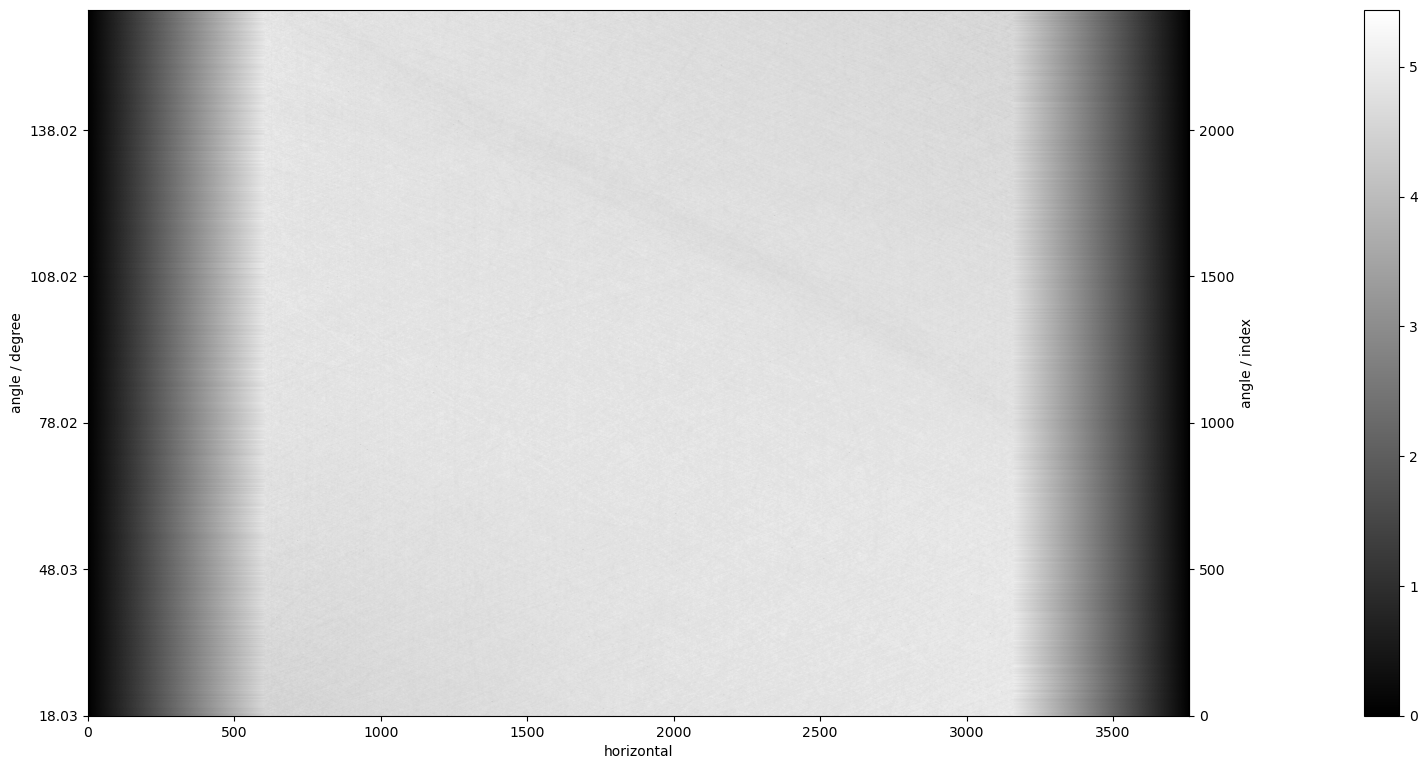

In [17]:
padsize = 600
# data_slice = Padder.constant( padsize, float(data_slice.mean()))(data_slice)
# data_pad = Padder.edge(pad_width={'horizontal': padsize})(data_slice)
data_slice = Padder.linear_ramp(padsize, 0)(data_slice)
show2D(data_slice)

FBP recon

Input Data:
	angle: 2410
	horizontal: 3760

Reconstruction Volume:
	horizontal_y: 2560
	horizontal_x: 2560

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



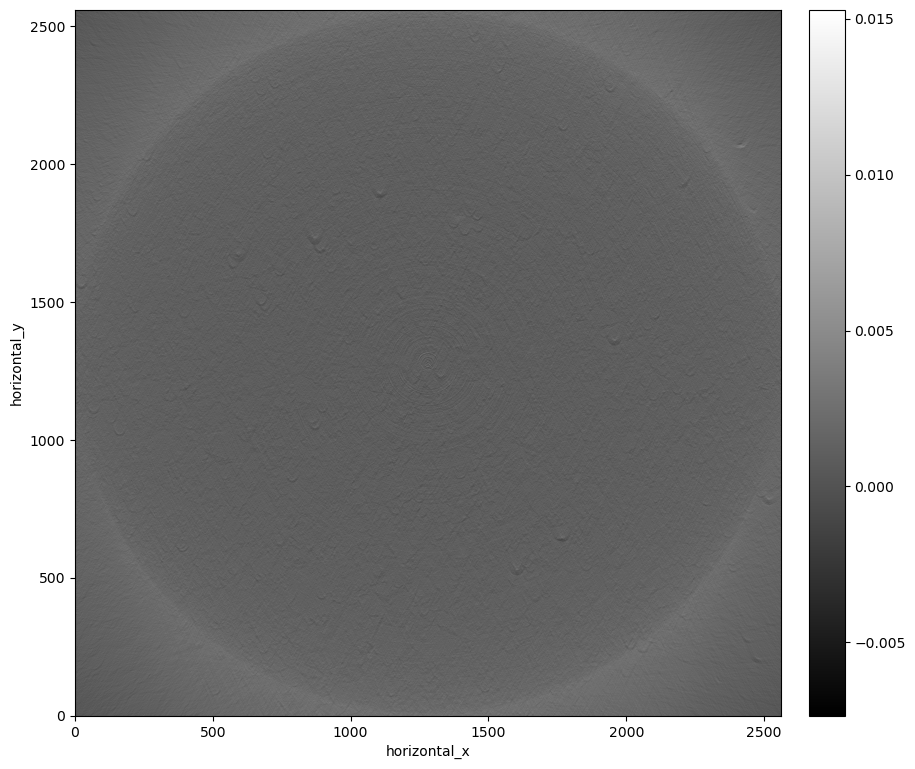

In [18]:
reco = FBP(data_slice, ig).run()
# reco.apply_circular_mask(0.99)
show2D(reco)

Finish Ring Remover
FBP recon

Input Data:
	angle: 2410
	horizontal: 3760

Reconstruction Volume:
	horizontal_y: 2560
	horizontal_x: 2560

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



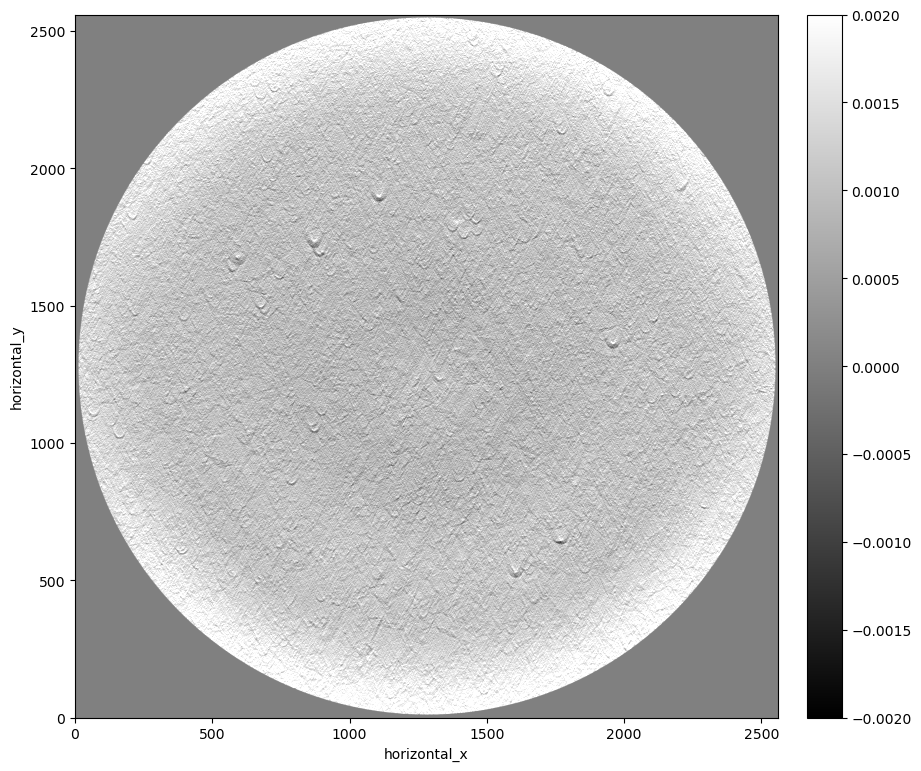

In [19]:
r = RingRemover(8,'db20', 1.5)
r.set_input(data_slice)
data_slice = r.get_output()
reco = FBP(data_slice, ig).run()
reco.apply_circular_mask(0.99)
show2D(reco, fix_range=(-0.002, 0.002))

FBP recon

Input Data:
	angle: 2410
	horizontal: 3760

Reconstruction Volume:
	horizontal_y: 2560
	horizontal_x: 2560

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



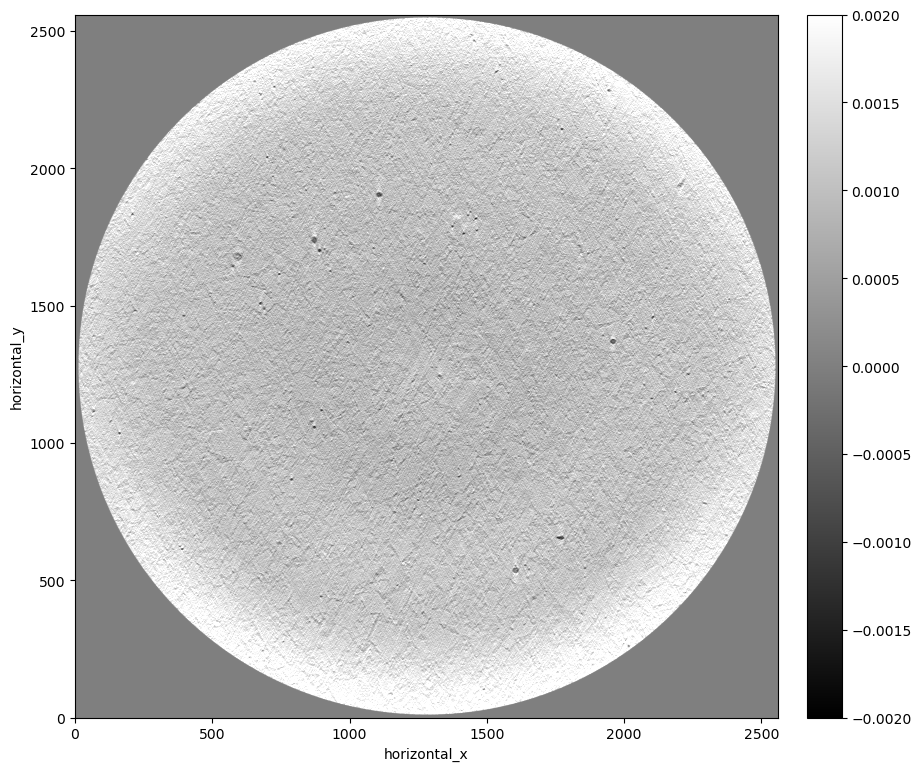

In [20]:
data_slice.geometry.set_centre_of_rotation(16.5, distance_units='pixels')
reco = FBP(data_slice, ig).run()
reco.apply_circular_mask(0.99)
show2D(reco, fix_range=(-0.002, 0.002))

In [21]:
# fig, axs = plt.subplots(1,5, figsize=(20,5))
# fig2, axs2 = plt.subplots(1,5, figsize=(20,5))

# reco = FBP(data_slice, ig).run()
# reco.apply_circular_mask(0.99)
# i=0
# axs[i].imshow(reco.array, cmap='gray')
# axs[i].set_title(r'$\alpha = $' + str(0))
# axs[i].set_xlabel('horizontal_x')
# axs[i].set_ylabel('horizontal_y')
# axs2[i].plot(reco.array[:,int(reco.shape[0]/2)])
# axs2[i].set_title(r'$\alpha = $' + str(0))
# axs2[i].set_xlabel('horizontal_x')
# axs2[i].set_ylabel('intensity')
# axs2[i].set_ylim([-0.003, 0.004])


# alphas = [0.0001, 0.0005, 0.001, 0.005]
# i=1
# for alpha in alphas: 
#     temp = data_slice.array.reshape(data_slice.shape + (1,))
#     temp = retrieve_phase(temp, alpha=alpha)
#     temp = temp.squeeze()
#     temp = AcquisitionData(temp, deep_copy=False, geometry = data_slice.geometry)
#     reco = FBP(temp, ig).run()
#     reco.apply_circular_mask(0.99)
#     axs[i].imshow(reco.array, cmap='gray')
#     axs[i].set_title(r'$\alpha = $' + str(alpha))
#     axs[i].set_xlabel('horizontal_x')
#     axs[i].set_ylabel('horizontal_y')
#     axs2[i].plot(reco.array[:,int(reco.shape[0]/2)])
#     axs2[i].set_title(r'$\alpha = $' + str(alpha))
#     axs2[i].set_xlabel('horizontal_x')
#     axs2[i].set_ylabel('intensity')
#     axs2[i].set_ylim([-0.003, 0.004])

#     i+=1

In [22]:
temp = data_slice.array.reshape(data_slice.shape + (1,))
alpha = 0.005
temp = retrieve_phase(temp, pixel_size=6.5e-4, dist=30, energy=19,  alpha=alpha)
temp = temp.squeeze()
data_slice = AcquisitionData(temp, deep_copy=False, geometry = data_slice.geometry)

FBP recon

Input Data:
	angle: 2410
	horizontal: 3760

Reconstruction Volume:
	horizontal_y: 2560
	horizontal_x: 2560

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



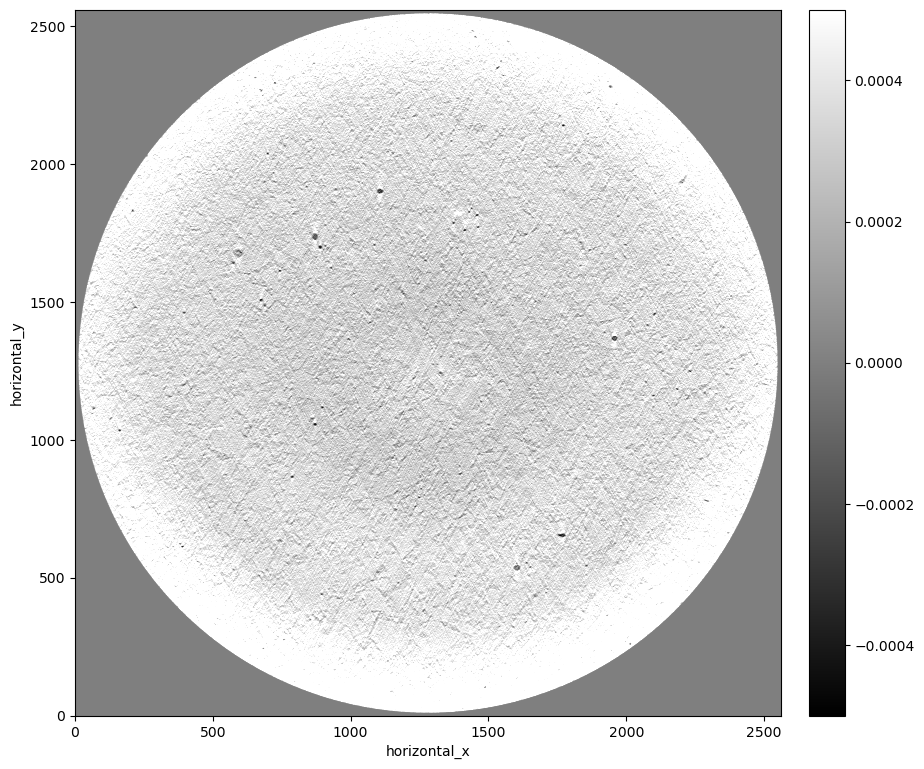

In [23]:
reco_FBP = FBP(data_slice, ig).run()
reco_FBP.apply_circular_mask(0.99)
show2D(reco_FBP, fix_range=(-0.0005, 0.0005))

In [24]:
from cil.optimisation.functions import L2NormSquared, BlockFunction, L1Norm, ZeroFunction, MixedL21Norm, IndicatorBox, TotalVariation
from cil.optimisation.algorithms import PDHG
from cil.optimisation.operators import BlockOperator, FiniteDifferenceOperator, GradientOperator
from cil.plugins.astra.operators import ProjectionOperator

In [25]:
def algo_anisotropic_TV(data_slice, scale_x=0, scale_y=0, initial=None):

    ag = data_slice.geometry
    ig = ag.get_ImageGeometry()
    F = BlockFunction(L2NormSquared(b=data_slice), 
                    L1Norm(),
                    L1Norm())

    A = ProjectionOperator(ig, ag, device="gpu")
    Dx = FiniteDifferenceOperator(ig, direction='horizontal_x')
    Dy = FiniteDifferenceOperator(ig, direction='horizontal_y')
    ratio_x = A.norm()/Dx.norm()
    alpha_x = ratio_x*scale_x
    ratio_y = A.norm()/Dy.norm()
    alpha_y = ratio_y*scale_y
    K = BlockOperator(A, 
                    alpha_x*Dx,
                    alpha_y*Dy)
    
    G = ZeroFunction()

    normK = K.norm()
    sigma = 0.5
    tau = 1./(sigma*normK**2)

    myPDHG = PDHG(f=F, 
                g=G, 
                operator=K, 
                sigma = sigma, tau = tau,
                initial = initial,
                max_iteration=2000, 
                update_objective_interval = 10,
                )

    myPDHG.run(1000,verbose=2)
    
    return myPDHG

In [26]:
def algo_isotropic_TV(data_slice, alpha, initial=None):

    ag = data_slice.geometry
    ig = ag.get_ImageGeometry()

    F = BlockFunction(alpha * MixedL21Norm(),
        0.5*L2NormSquared(b=data_slice))

    K = BlockOperator(GradientOperator(ig), 
                      ProjectionOperator(ig, ag, device="gpu"))
    
    G = IndicatorBox(lower=0)

    normK = K.norm()
    sigma = 0.5
    tau = 1./(sigma*normK**2)

    myPDHG = PDHG(f=F, 
                g=G, 
                operator=K, 
                sigma = sigma, tau = tau,
                initial = initial,
                max_iteration=2000, 
                update_objective_interval = 10,
                )

    myPDHG.run(100,verbose=2)
    
    return myPDHG

In [27]:
def algo_isotropic_TV_implicit(data_slice, alpha, initial=None):

    ag = data_slice.geometry
    ig = ag.get_ImageGeometry()

    F = 0.5 * L2NormSquared(b=data_slice)
    
    G = (alpha/ig.voxel_size_y) *TotalVariation(max_iteration=10)
    
    K = ProjectionOperator(ig, ag, device='gpu')

    normK = K.norm()
    sigma = 0.5
    tau = 1./(sigma*normK**2)

    myPDHG = PDHG(f=F, 
                g=G, 
                operator=K, 
                sigma = sigma, tau = tau,
                initial = initial,
                max_iteration=2000, 
                update_objective_interval = 10,
                )

    myPDHG.run(100,verbose=2)
    
    return myPDHG

In [30]:
myPDHG1 = algo_isotropic_TV_implicit(data_slice, alpha=0.0005, initial=None)
reco1 = myPDHG1.solution
# # reco1.apply_circular_mask(0.5)

myPDHG2 = algo_isotropic_TV_implicit(data_slice, alpha=0.005, initial=None)
reco2 = myPDHG2.solution
# reco2.apply_circular_mask(0.5)

myPDHG3 = algo_isotropic_TV_implicit(data_slice, alpha=0.05, initial=None)
reco3 = myPDHG3.solution
# reco2.apply_circular_mask(0.5)

myPDHG4 = algo_isotropic_TV_implicit(data_slice, alpha=0.5, initial=None)
reco4 = myPDHG4.solution
# reco2.apply_circular_mask(0.5)

     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0       2000         0.000    1.00911e+07  -0.00000e+00    1.00911e+07
       10       2000         6.108    7.96538e+03   4.72112e+04   -3.92458e+04
       20       2000         5.908    4.94379e+03   8.07363e+03   -3.12985e+03
       30       2000         5.893    4.29450e+03   6.57784e+03   -2.28335e+03
       40       2000         5.954    3.94738e+03   5.84497e+03   -1.89759e+03
       50       2000         5.937    3.72866e+03   5.33850e+03   -1.60984e+03
       60       2000         5.917    3.57855e+03   4.97738e+03   -1.39884e+03
       70       2000         5.922    3.46893e+03   4.70475e+03   -1.23582e+03
       80       2000         5.906    3.38471e+03   4.49191e+03   -1.10720e+03
       90       2000         5.918    3.31719e+03   4.32200e+03   -1.00480e+03
      100       2000         5.918    3.26110e+03   

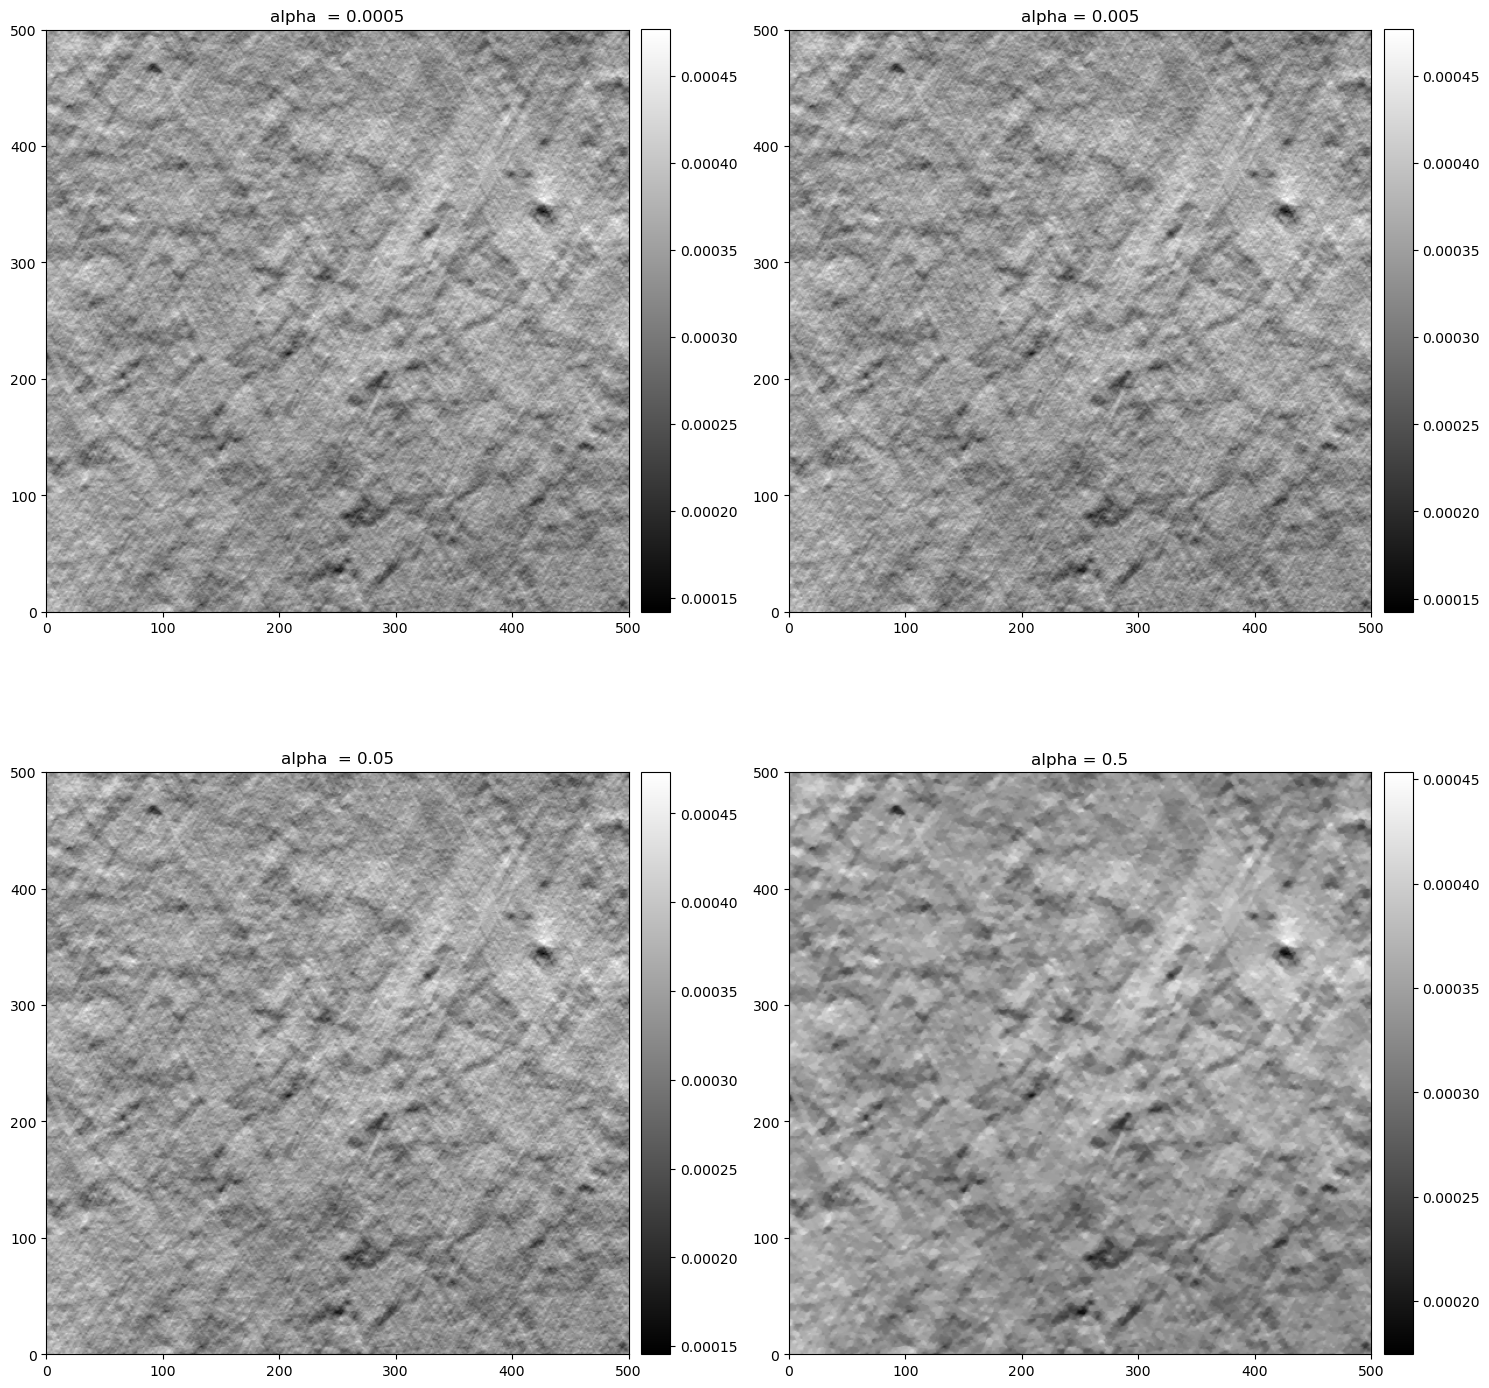

In [36]:
# reco = myPDHG.solution
show2D([reco1.array[1500:2000,1500:2000], reco2.array[1500:2000,1500:2000],
        reco3.array[1500:2000,1500:2000], reco4.array[1500:2000,1500:2000]],
        title = ['alpha  = 0.0005', 'alpha = 0.005',
                 'alpha  = 0.05', 'alpha = 0.5'])

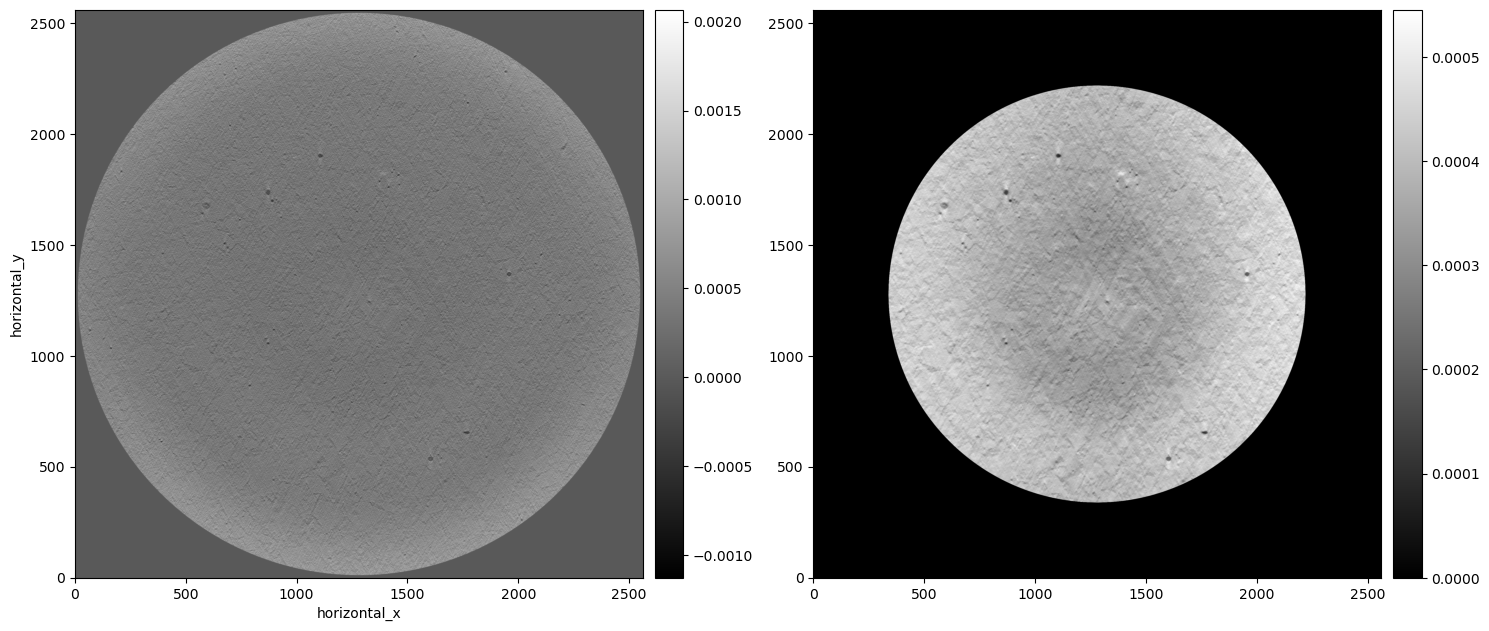

In [66]:
reco4.apply_circular_mask(1)
show2D([reco_FBP, reco4.array[600:3160,600:3160]])

In [62]:
padsize

600

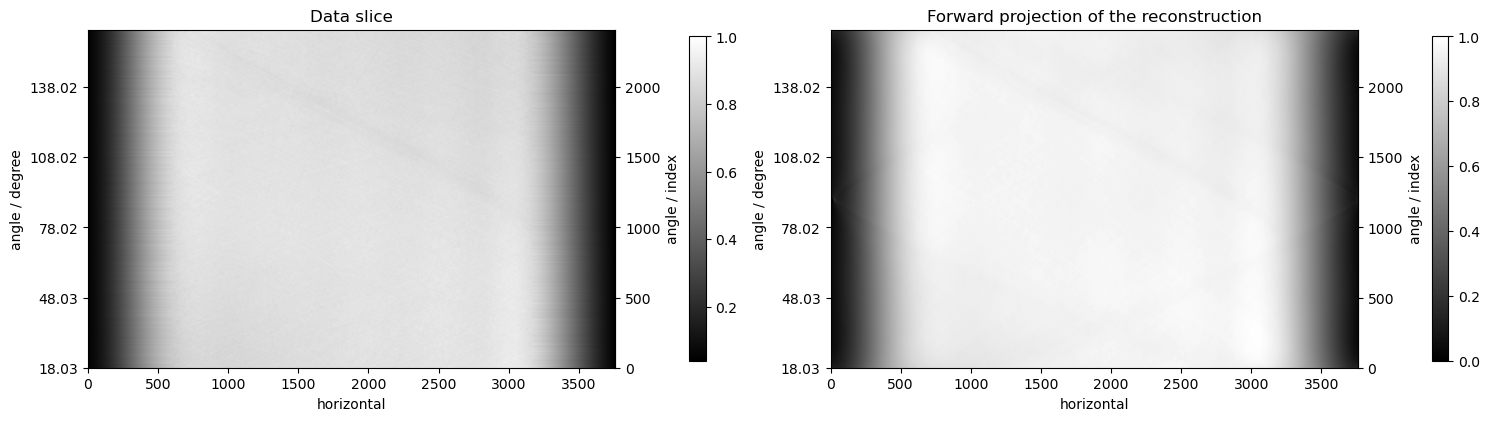

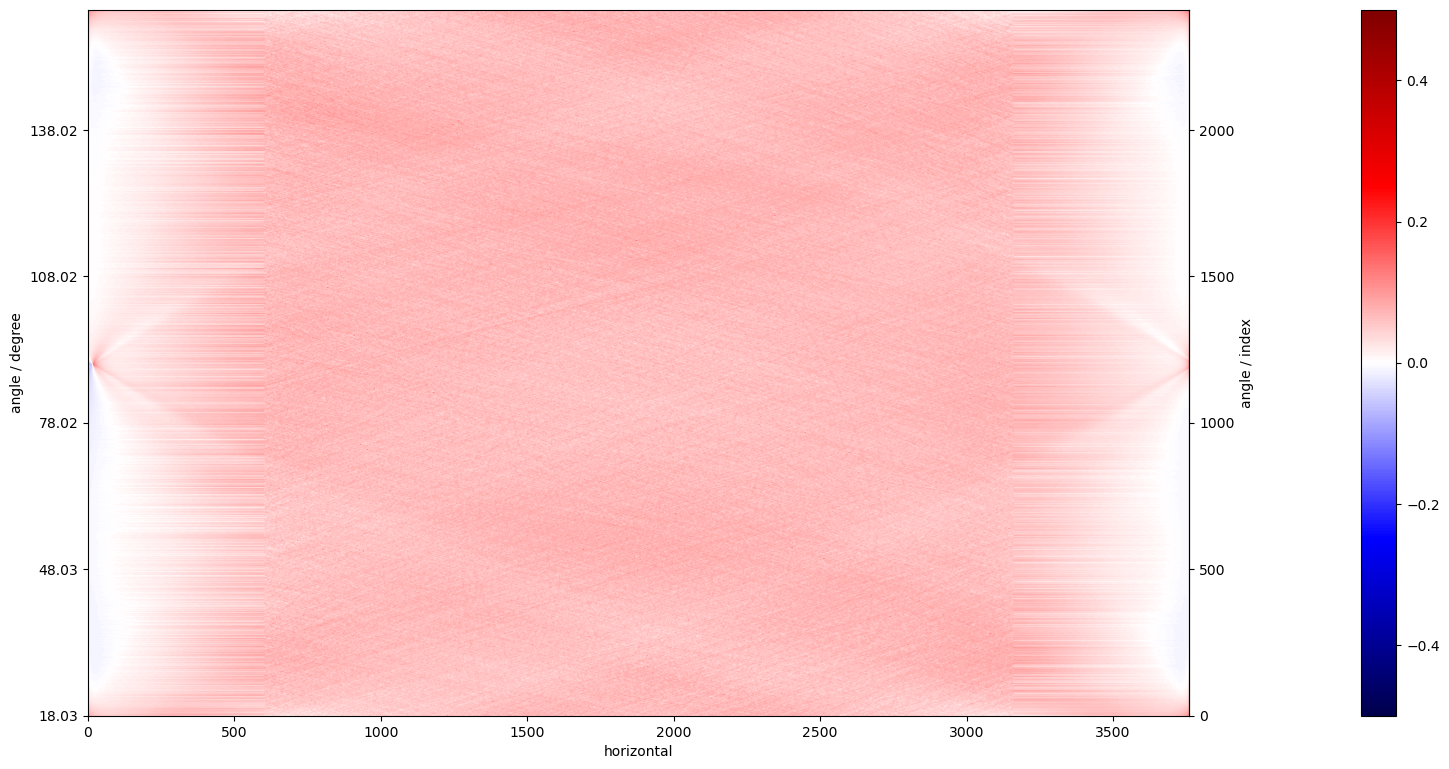

In [56]:
forward_projection = ProjectionOperator(reco.geometry, data_slice.geometry).direct(reco)
residuals = forward_projection/np.max(forward_projection) - data_slice/np.max(data_slice)


show2D([data_slice/np.max(data_slice), forward_projection/np.max(forward_projection)],title=['Data slice', 'Forward projection of the reconstruction'])
show2D(residuals, fix_range = (-0.5, 0.5), cmap='seismic')

In [ ]:
from cil.plugins.astra import FBP

     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0       1000         0.000    3.33900e+06  -0.00000e+00    3.33900e+06
       10       1000         1.782    5.87173e+05  -1.23055e+09    1.23113e+09
       20       1000         1.786    5.08073e+05  -7.34880e+08    7.35389e+08
       30       1000         1.792    4.28042e+05  -5.38128e+08    5.38557e+08
       40       1000         1.789    3.66870e+05  -4.24431e+08    4.24798e+08
       50       1000         1.790    3.14002e+05  -3.56187e+08    3.56501e+08
----------------------------------------------------------------------------
       50       1000         1.790    3.14002e+05  -3.56187e+08    3.56501e+08
Stop criterion has been reached.



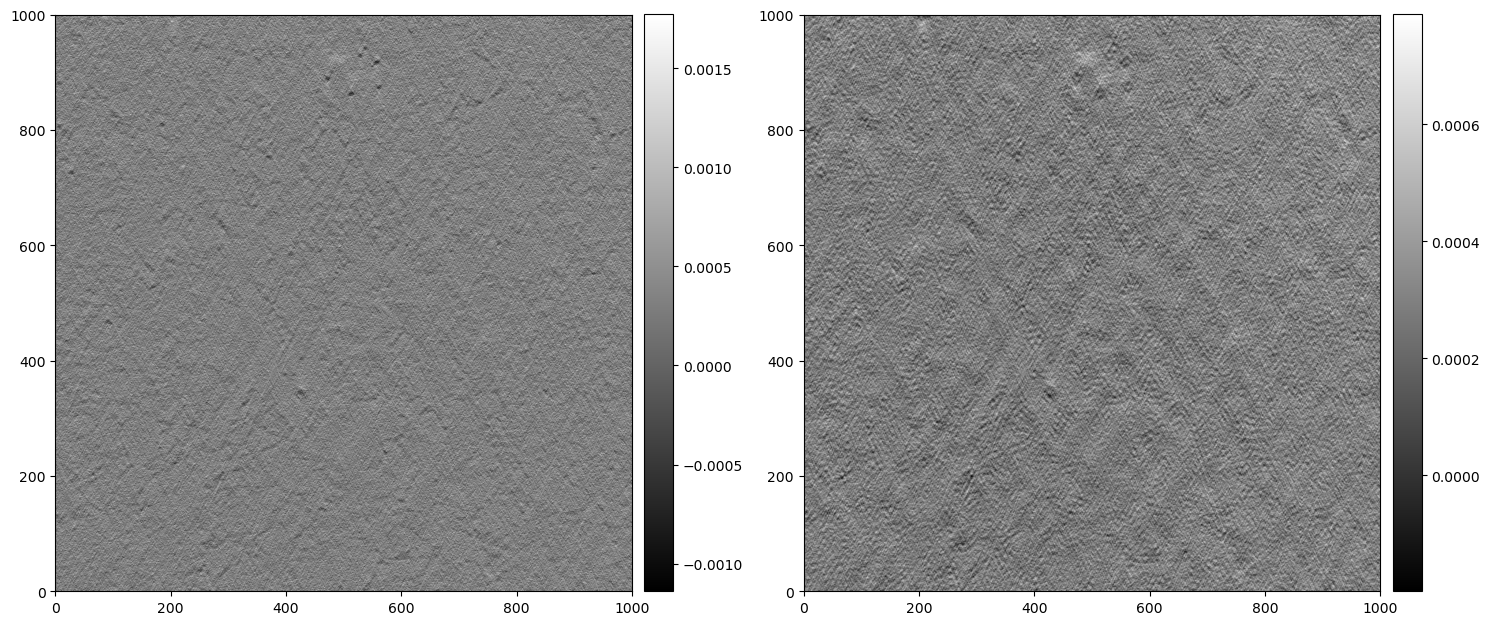

In [ ]:
data_phase = data_slice.array.reshape(data_slice.shape + (1,))
alpha = 0.005
data_phase = retrieve_phase(data_phase, pixel_size=6.5e-4, dist=30, energy=19,  alpha=alpha)
data_phase = data_phase.squeeze()
data_phase = AcquisitionData(data_phase, deep_copy=False, geometry = data_slice.geometry)

# reco_phase_FBP = FBP(data_phase, ig_prepad, backend='astra').run()
reco_phase_FBP = FBP(ig, ag, device='gpu')(data_phase)
reco_phase_FBP = Padder.constant( padsize, float(reco_phase_FBP.mean()))(reco_phase_FBP)
reco_phase = algo(data_phase, initial=reco_phase_FBP)

show2D([reco_phase_FBP.array[1500:2500,1500:2500], reco_phase.array[1500:2500,1500:2500]])

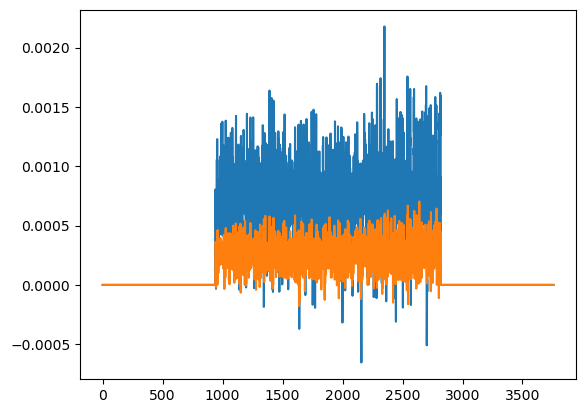

In [ ]:
plt.plot(reco.array[:,int(reco.shape[0]/2)])
plt.plot(reco_phase.array[:,int(reco.shape[0]/2)])